#1.Load and Transform Data

###1.1 Mount Google Drive

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
except:
    print("Drive mount failed. Restart runtime then try again.")

Mounted at /content/drive


###1.2 Setup Path File dan Extract Folder

In [2]:
import os

# Folder tempat menyimpan file
DRIVE_BASE = '/content/drive/MyDrive/DATA PJBL DEEL B'

# File ZIP gambar
DRIVE_ZIP_PATH = os.path.join(DRIVE_BASE, 'img.zip')

# Folder anotasi
ANNOT_DIR = DRIVE_BASE

# Lokasi extract di storage Colab
EXTRACT_TO = '/content/deepfashion_img'

print("DRIVE_ZIP_PATH:", DRIVE_ZIP_PATH)
print("ANNOT_DIR:", ANNOT_DIR)
print("EXTRACT_TO:", EXTRACT_TO)


DRIVE_ZIP_PATH: /content/drive/MyDrive/DATA PJBL DEEL B/img.zip
ANNOT_DIR: /content/drive/MyDrive/DATA PJBL DEEL B
EXTRACT_TO: /content/deepfashion_img


###1.3 Extract ZIP

In [3]:
import zipfile

if not os.path.exists(EXTRACT_TO):
    print("Extracting img.zip")
    with zipfile.ZipFile(DRIVE_ZIP_PATH, 'r') as z:
        z.extractall(EXTRACT_TO)
    print("Extraction selesai!")
else:
    print("Folder gambar sudah ada, skip extract.")

Folder gambar sudah ada, skip extract.


#2.Data Preparation

###2.1 Kumpulkan Semua Gambar dan Label

In [4]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split

# Lokasi gambar setelah extract
IMG_ROOT = EXTRACT_TO + "/img"

image_paths = []
labels = []

for root, dirs, files in os.walk(IMG_ROOT):
    for f in files:
        if f.lower().endswith(('.jpg', '.jpeg', '.png')):
            full_path = os.path.join(root, f)
            folder = Path(full_path).parts[-2]
            image_paths.append(full_path)
            labels.append(folder)

df = pd.DataFrame({
    'path': image_paths,
    'label_name': labels
})

print("Total images awal      :", len(df))
print("Total categories awal  :", df['label_name'].nunique())
df

Total images awal      : 289229
Total categories awal  : 5621


,path,label_name
0,/content/deepfashion_img/img/Colorblocked_Touj...,Colorblocked_Toujours_la_V&ocirc;tre_Tank
1,/content/deepfashion_img/img/Colorblocked_Touj...,Colorblocked_Toujours_la_V&ocirc;tre_Tank
2,/content/deepfashion_img/img/Colorblocked_Touj...,Colorblocked_Toujours_la_V&ocirc;tre_Tank
3,/content/deepfashion_img/img/Colorblocked_Touj...,Colorblocked_Toujours_la_V&ocirc;tre_Tank
4,/content/deepfashion_img/img/Colorblocked_Touj...,Colorblocked_Toujours_la_V&ocirc;tre_Tank
...,...,...
289224,/content/deepfashion_img/img/Crinkled_Crepe_Ha...,Crinkled_Crepe_Halter_Dress
289225,/content/deepfashion_img/img/Crinkled_Crepe_Ha...,Crinkled_Crepe_Halter_Dress
289226,/content/deepfashion_img/img/Crinkled_Crepe_Ha...,Crinkled_Crepe_Halter_Dress
289227,/content/deepfashion_img/img/Crinkled_Crepe_Ha...,Crinkled_Crepe_Halter_Dress


###2.2 Filter Kategori

In [5]:
# Menghitung jumlah gambar per kategori
counts = df['label_name'].value_counts()

# Menyaring kategori yang memiliki lebih dari atau sama dengan 130 gambar
valid_categories = counts[counts >= 130].index

# Filter dataframe hanya untuk kategori yang valid
df_filtered = df[df['label_name'].isin(valid_categories)].reset_index(drop=True)

# Menampilkan hasil
print("Total images setelah filter:", len(df_filtered))
print("Total kategori        :", df_filtered['label_name'].nunique())

# Jika ingin menggunakan df_filtered untuk proses selanjutnya
df = df_filtered


Total images setelah filter: 9285
Total kategori        : 64


###2.3 Encode Label Jadi Angka

In [6]:
label_to_idx = {name: i for i, name in enumerate(sorted(df['label_name'].unique()))}
df['label'] = df['label_name'].map(label_to_idx)
df

,path,label_name,label
0,/content/deepfashion_img/img/Button-Front_Blaz...,Button-Front_Blazer,3
1,/content/deepfashion_img/img/Button-Front_Blaz...,Button-Front_Blazer,3
2,/content/deepfashion_img/img/Button-Front_Blaz...,Button-Front_Blazer,3
3,/content/deepfashion_img/img/Button-Front_Blaz...,Button-Front_Blazer,3
4,/content/deepfashion_img/img/Button-Front_Blaz...,Button-Front_Blazer,3
...,...,...,...
9280,/content/deepfashion_img/img/Ruffled_Lace-Up_B...,Ruffled_Lace-Up_Blouse,39
9281,/content/deepfashion_img/img/Ruffled_Lace-Up_B...,Ruffled_Lace-Up_Blouse,39
9282,/content/deepfashion_img/img/Ruffled_Lace-Up_B...,Ruffled_Lace-Up_Blouse,39
9283,/content/deepfashion_img/img/Ruffled_Lace-Up_B...,Ruffled_Lace-Up_Blouse,39


###2.4 Pembagian Data (Train, Validation, Test)

In [7]:
# Data Train
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

# Data Val/Test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    shuffle=True
)

print("UKURAN DATASET:")
print("Train  :", len(train_df))
print("Val    :", len(val_df))
print("Test   :", len(test_df))

UKURAN DATASET:
Train  : 7428
Val    : 928
Test   : 929


###2.5 Simpan dataset ke CSV

In [8]:
train_df.to_csv(f"{EXTRACT_TO}/train_manifest.csv", index=False)
val_df.to_csv(f"{EXTRACT_TO}/val_manifest.csv", index=False)
test_df.to_csv(f"{EXTRACT_TO}/test_manifest.csv", index=False)

print("\nManifest files saved.")


Manifest files saved.


###2.6 Data Augmentation

In [9]:
import tensorflow as tf

IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# EfficientNet preprocessor
preprocess = tf.keras.applications.efficientnet.preprocess_input

#Function load & preprocess image
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = preprocess(img)
    return img, label

#Augmentasi untuk training
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
])

def load_image_train(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = data_augmentation(img)
    img = preprocess(img)
    return img, label

###2.7 Dataset Pipeline

In [10]:
#DataFrame → tf.data
def df_to_dataset(df, training=False):
    paths = df['path'].values
    labels = df['label'].values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    if training:
        ds = ds.shuffle(buffer_size=len(df))
        ds = ds.map(load_image_train, num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(load_image, num_parallel_calls=AUTOTUNE)

    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds = df_to_dataset(train_df, training=True)
val_ds   = df_to_dataset(val_df, training=False)
test_ds  = df_to_dataset(test_df, training=False)

print("Train batches:", len(train_ds))
print("Val batches:", len(val_ds))
print("Test batches:", len(test_ds))


Train batches: 233
Val batches: 29
Test batches: 30


###2.8 Visualization image dari dataset

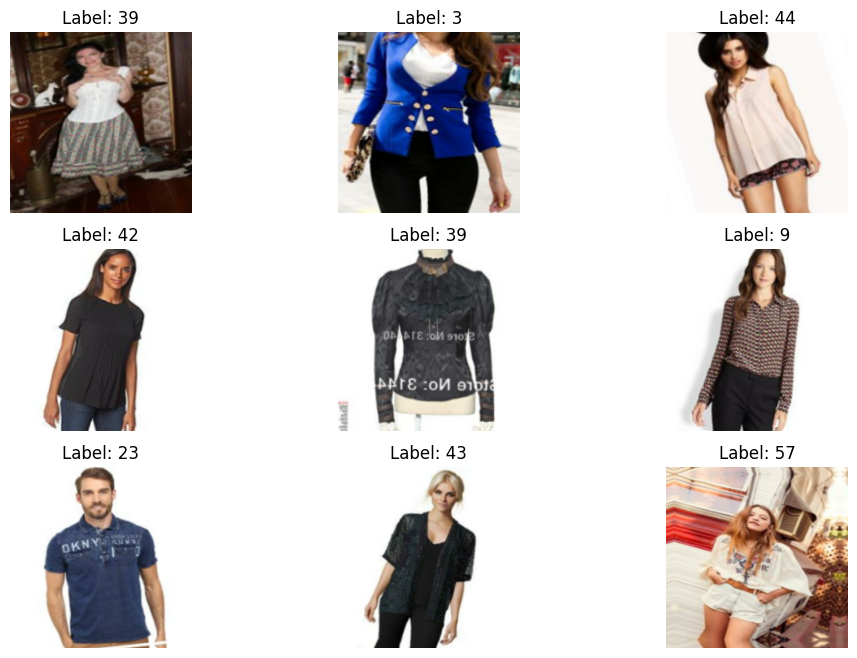

In [11]:
import matplotlib.pyplot as plt

batch_images, batch_labels = next(iter(train_ds))

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(batch_images[i].numpy().astype("uint8"))
    plt.title(f"Label: {batch_labels[i].numpy()}")
    plt.axis("off")
plt.show()


#3.Model Building

## 3.1 Baseline: Fine-grained Classification (64 Classes)

###a. Memuat model EfficientNetB0

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Jumlah kelas dan ukuran gambar
IMG_SIZE = 224
NUM_CLASSES = df['label'].nunique()  # = 64
BATCH_SIZE = 32

# Load model pre-trained EfficientNetB0
pretrained_model = tf.keras.applications.EfficientNetB0(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

# Freeze base model
pretrained_model.trainable = False

###b. Membuat Model Kustom untuk Klasifikasi

In [13]:
# Membuat layer custom untuk klasifikasi
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = pretrained_model(inputs, training=False)  # Freeze base model
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.45)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.45)(x)

# Output layer untuk klasifikasi
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

# Model akhir
model = models.Model(inputs=inputs, outputs=outputs)

###c. Kompilasi Model

In [14]:
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,264,547 (16.27 MB)

 Trainable params: 214,208 (836.75 KB)

 Non-trainable params: 4,050,339 (15.45 MB)

###d. Membuat Callback untuk Model Checkpoint dan EarlyStopping

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Membuat callback untuk menyimpan model terbaik
checkpoint_path = "indo_fashion_classification_model_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Early stopping jika validasi loss tidak membaik
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Mengurangi learning rate jika validasi loss tidak membaik
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

###e. Latih Model

In [16]:
# Menyiapkan dataset
train_ds = df_to_dataset(train_df, training=True)
val_ds = df_to_dataset(val_df, training=False)

# Melatih model
history = model.fit(
    train_ds,
    steps_per_epoch=len(train_ds),
    validation_data=val_ds,
    validation_steps=len(val_ds),
    epochs=20,
    callbacks=[
        early_stopping,
        checkpoint_callback,
        reduce_lr
    ]
)


Epoch 1/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 132s 440ms/step - accuracy: 0.0123 - loss: 5.4225 - val_accuracy: 0.0442 - val_loss: 4.2004 - learning_rate: 1.0000e-04
Epoch 2/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 76s 327ms/step - accuracy: 0.0338 - loss: 4.9575 - val_accuracy: 0.0625 - val_loss: 3.9072 - learning_rate: 1.0000e-04
Epoch 3/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 82s 327ms/step - accuracy: 0.0436 - loss: 4.6456 - val_accuracy: 0.1013 - val_loss: 3.7264 - learning_rate: 1.0000e-04
Epoch 4/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 82s 327ms/step - accuracy: 0.0529 - loss: 4.4247 - val_accuracy: 0.1282 - val_loss: 3.6119 - learning_rate: 1.0000e-04
Epoch 5/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 77s 328ms/step - accuracy: 0.0726 - loss: 4.2188 - val_accuracy: 0.1444 - val_loss: 3.4805 - learning_rate: 1.0000e-04
Epoch 6/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 82s 327ms/step - accuracy: 0.0820 - loss: 4.0517 - val_accuracy: 0.1649 - val_loss: 3.3835 - learning_rate: 1.0000e-04
Epoch 7/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 78s 3

In [17]:
# Menyimpan model
model.save("fashion_FineGrainedClassification_model.keras")

##3.2 Proposed Method: Coarse-grained Classification (4 Classes)

####a. Pre-processing Coarse-grained Classification

In [18]:
# Coarse-Grained Label Construction
def simplify_label(name):
    name = name.lower()

    if "blouse" in name:
        return "Blouse"
    elif "blazer" in name:
        return "Blazer"
    elif "dress" in name:
        return "Dress"
    elif "sweater" in name or "knit" in name:
        return "Sweater"
    elif "bomber" in name or "jacket" in name:
        return "Jacket"
    elif "anorak" in name or "coat" in name:
        return "Coat"
    elif "pants" in name or "jeans" in name or "skirt" in name:
        return "Bottom"
    else:
        return "Other"

In [19]:
# Coarse-Grained Label Mapping (CG)

# Membuat label coarse-grained (CG)
df["cg_label_name"] = df["label_name"].apply(simplify_label)

# Cek distribusi label CG
print(df["cg_label_name"].value_counts())

cg_label_name
Blouse    5438
Blazer    3378
Jacket     309
Coat       160
Name: count, dtype: int64


In [20]:
# Encoding Coarse-Grained Labels

# Mapping label CG ke indeks numerik
cg_label_map = {
    name: i for i, name in enumerate(sorted(df["cg_label_name"].unique()))
}

# Encode label
df["cg_label"] = df["cg_label_name"].map(cg_label_map)

# Jumlah kelas CG
CG_NUM_CLASSES = len(cg_label_map)
print("CG_NUM_CLASSES:", CG_NUM_CLASSES)

CG_NUM_CLASSES: 4


In [21]:
# Train / Validation / Test Split (Coarse-Grained)
from sklearn.model_selection import train_test_split

# Data Train (CG)
cg_train_df, cg_temp_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["cg_label"]
)

# Data Validation & Test (CG)
cg_val_df, cg_test_df = train_test_split(
    cg_temp_df,
    test_size=0.5,
    random_state=42,
    stratify=cg_temp_df["cg_label"]
)

print("UKURAN DATASET COARSE-GRAINED:")
print("Train :", len(cg_train_df))
print("Val   :", len(cg_val_df))
print("Test  :", len(cg_test_df))

UKURAN DATASET COARSE-GRAINED:
Train : 7428
Val   : 928
Test  : 929


In [22]:
# Image Preprocessing & Data Augmentation (Coarse-Grained)
import tensorflow as tf

CG_IMG_SIZE = 224
CG_BATCH_SIZE = 32
CG_AUTOTUNE = tf.data.AUTOTUNE

# EfficientNet preprocessor (CG)
cg_preprocess = tf.keras.applications.efficientnet.preprocess_input

# Load & preprocess image (validation / test)
def cg_load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (CG_IMG_SIZE, CG_IMG_SIZE))
    img = cg_preprocess(img)
    return img, label

# Data augmentation (training only)
cg_data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
])

# Load, augment, & preprocess image (training)
def cg_load_image_train(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (CG_IMG_SIZE, CG_IMG_SIZE))
    img = cg_data_augmentation(img)
    img = cg_preprocess(img)
    return img, label

In [23]:
# DataFrame → tf.data Pipeline Construction (Coarse-Grained)
def cg_df_to_dataset(df, training=False):
    paths = df["path"].values
    labels = df["cg_label"].values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    if training:
        ds = ds.shuffle(buffer_size=len(df))
        ds = ds.map(cg_load_image_train, num_parallel_calls=CG_AUTOTUNE)
    else:
        ds = ds.map(cg_load_image, num_parallel_calls=CG_AUTOTUNE)

    ds = ds.batch(CG_BATCH_SIZE)
    ds = ds.prefetch(CG_AUTOTUNE)
    return ds

cg_train_ds = cg_df_to_dataset(cg_train_df, training=True)
cg_val_ds   = cg_df_to_dataset(cg_val_df, training=False)
cg_test_ds  = cg_df_to_dataset(cg_test_df, training=False)

print("CG Train batches:", len(cg_train_ds))
print("CG Val batches  :", len(cg_val_ds))
print("CG Test batches :", len(cg_test_ds))

CG Train batches: 233
CG Val batches  : 29
CG Test batches : 30


###b. Memuat model EfficientNetB0 Coarse-Grained

In [24]:
CG_NUM_CLASSES = 4

cg_base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(CG_IMG_SIZE, CG_IMG_SIZE, 3),
    pooling="avg"
)

# Freeze base model
cg_base_model.trainable = False

###c. Membuat Model Kustom untuk Coarse-Grained Classification

In [25]:
cg_inputs = tf.keras.Input(shape=(CG_IMG_SIZE, CG_IMG_SIZE, 3))
x = cg_base_model(cg_inputs, training=False)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
cg_outputs = tf.keras.layers.Dense(CG_NUM_CLASSES, activation="softmax")(x)

cg_model = tf.keras.Model(cg_inputs, cg_outputs)

###d. Kompilasi Model

In [26]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Callback (EarlyStopping)
cg_early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Compile model
cg_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
cg_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,379,559 (16.71 MB)

 Trainable params: 329,476 (1.26 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

###e. Latih Model

In [27]:
cg_history = cg_model.fit(
    cg_train_ds,
    validation_data=cg_val_ds,
    epochs=20,
    callbacks=[cg_early_stopping]
)

Epoch 1/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 114s 398ms/step - accuracy: 0.7000 - loss: 0.9830 - val_accuracy: 0.8675 - val_loss: 0.4111
Epoch 2/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 76s 327ms/step - accuracy: 0.8447 - loss: 0.4408 - val_accuracy: 0.8631 - val_loss: 0.3437
Epoch 3/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 83s 332ms/step - accuracy: 0.8559 - loss: 0.3983 - val_accuracy: 0.8761 - val_loss: 0.3328
Epoch 4/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 80s 326ms/step - accuracy: 0.8604 - loss: 0.3581 - val_accuracy: 0.8836 - val_loss: 0.3123
Epoch 5/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 75s 322ms/step - accuracy: 0.8709 - loss: 0.3384 - val_accuracy: 0.8761 - val_loss: 0.3588
Epoch 6/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 82s 321ms/step - accuracy: 0.8766 - loss: 0.3176 - val_accuracy: 0.8772 - val_loss: 0.3312
Epoch 7/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 80s 345ms/step - accuracy: 0.8829 - loss: 0.3044 - val_accuracy: 0.8912 - val_loss: 0.3102
Epoch 8/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 77s 332ms/step - accuracy: 0.8822 - loss: 

In [28]:
# Menyimpan model
cg_model.save("fashion_CoarceGrainedClassification_model.keras")

#4.Model Evaluation

###4.1 Fine-grained Classification (64 Class)

####a. Model Evaluation

In [29]:
test_ds = df_to_dataset(test_df, training=False)

test_loss, test_acc = model.evaluate(test_ds, steps=len(test_ds))
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 372ms/step - accuracy: 0.2844 - loss: 2.7267
Test Loss: 2.687899112701416
Test Accuracy: 0.2981700897216797


####b. Loss Curves Visualization

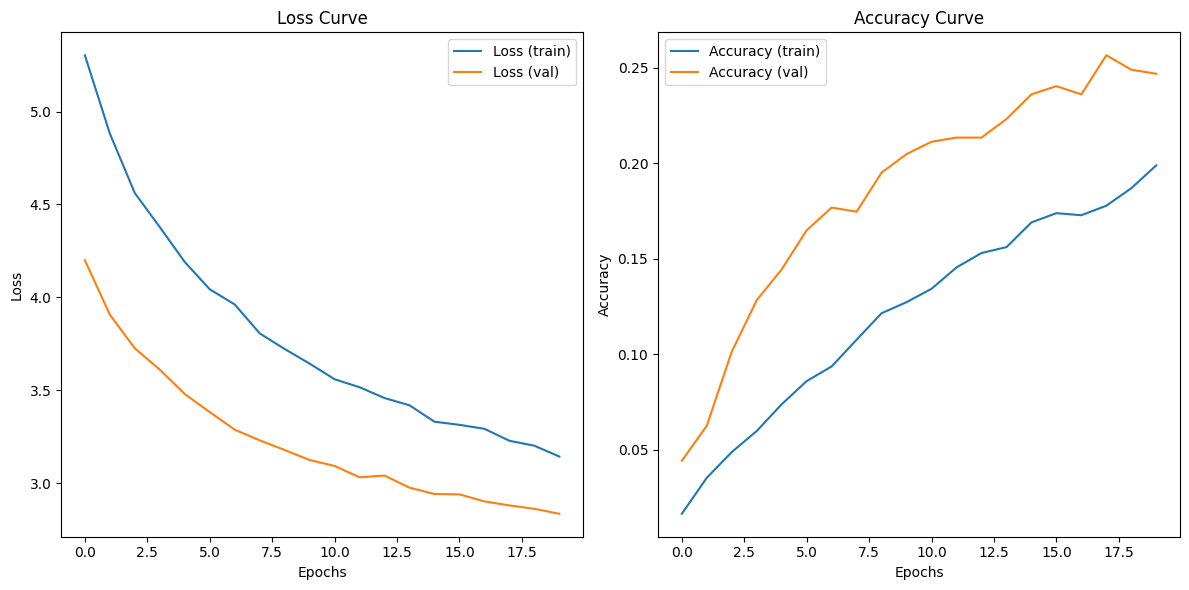

In [30]:
# Visualisasi kurva loss
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss (train)')
plt.plot(history.history['val_loss'], label='Loss (val)')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy (train)')
plt.plot(history.history['val_accuracy'], label='Accuracy (val)')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Menampilkan plot
plt.tight_layout()
plt.show()

###4.2 Coarse-grained Classification (4 Class)

####a. Model Evaluation

In [31]:
# Evaluasi model coarse-grained
cg_test_ds = cg_df_to_dataset(cg_test_df, training=False)

cg_test_loss, cg_test_acc = cg_model.evaluate(
    cg_test_ds,
    steps=len(cg_test_ds)
)

print(f"CG Test Loss     : {cg_test_loss:.4f}")
print(f"CG Test Accuracy : {cg_test_acc:.4f}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - accuracy: 0.8941 - loss: 0.2863
CG Test Loss     : 0.3213
CG Test Accuracy : 0.8784


####b. Loss Curves Visualization

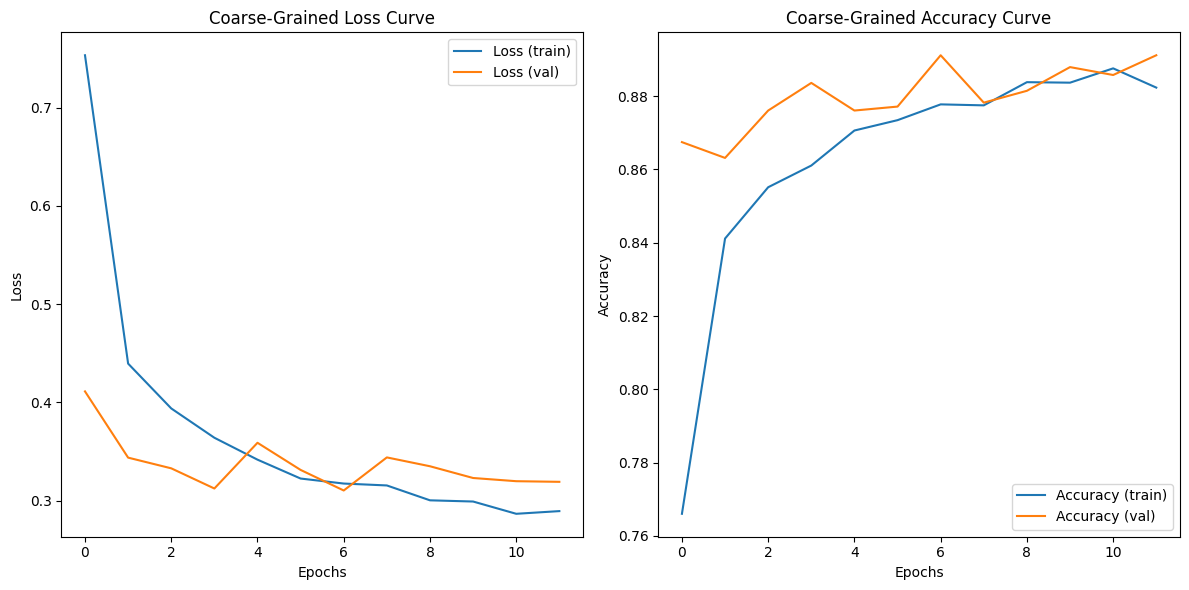

In [32]:
import matplotlib.pyplot as plt

cg_history_plot = cg_history  # history dari cg_model.fit()

plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(cg_history_plot.history["loss"], label="Loss (train)")
plt.plot(cg_history_plot.history["val_loss"], label="Loss (val)")
plt.title("Coarse-Grained Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(cg_history_plot.history["accuracy"], label="Accuracy (train)")
plt.plot(cg_history_plot.history["val_accuracy"], label="Accuracy (val)")
plt.title("Coarse-Grained Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# 5. Prediction Data test

###5.1 Fine-grained Classification (64 Class)

####a. Classification Report

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Mengambil prediksi untuk data uji
y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.append(labels.numpy())
    y_pred.append(model.predict(images))

# Mengubah prediksi dan labels ke bentuk yang sesuai
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_pred = np.argmax(y_pred, axis=-1)  # Convert logits to class labels

# Menghasilkan classification report
print("=== Fine-Grained Classification Report ===")
print(classification_report(y_true, y_pred, target_names=df['label_name'].unique()))

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━

In [34]:
def load_image_raw(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0   # cukup normal [0,1]
    return img

In [35]:
sample_df = test_df.sample(9, random_state=42)

images = []
labels = []

for _, row in sample_df.iterrows():
    img = load_image_raw(row['path'])
    images.append(img)
    labels.append(row['label'])

images = tf.stack(images)
labels = np.array(labels)

In [36]:
images_model = tf.keras.applications.efficientnet.preprocess_input(images * 255)

preds = model.predict(images_model)
preds = np.argmax(preds, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


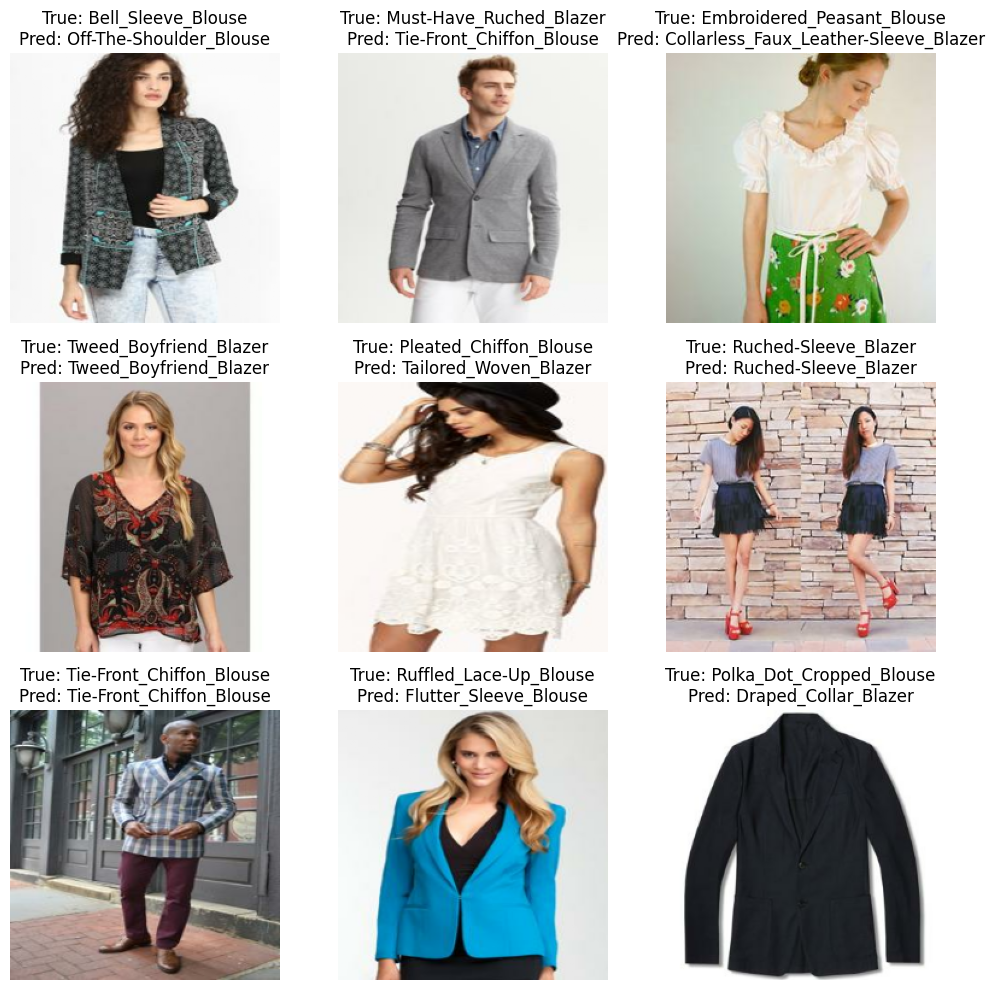

In [37]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy())
    plt.title(
        f"True: {df['label_name'].unique()[labels[i]]}\n"
        f"Pred: {df['label_name'].unique()[preds[i]]}"
    )
    plt.axis("off")

plt.tight_layout()
plt.show()

####b. Confusion Matrix

In [38]:
import numpy as np

# Ambil true labels
y_true = []
for _, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

# Prediksi model
y_pred_prob = model.predict(test_ds)
y_pred = np.argmax(y_pred_prob, axis=1)
cm = confusion_matrix(y_true, y_pred)

30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 291ms/step


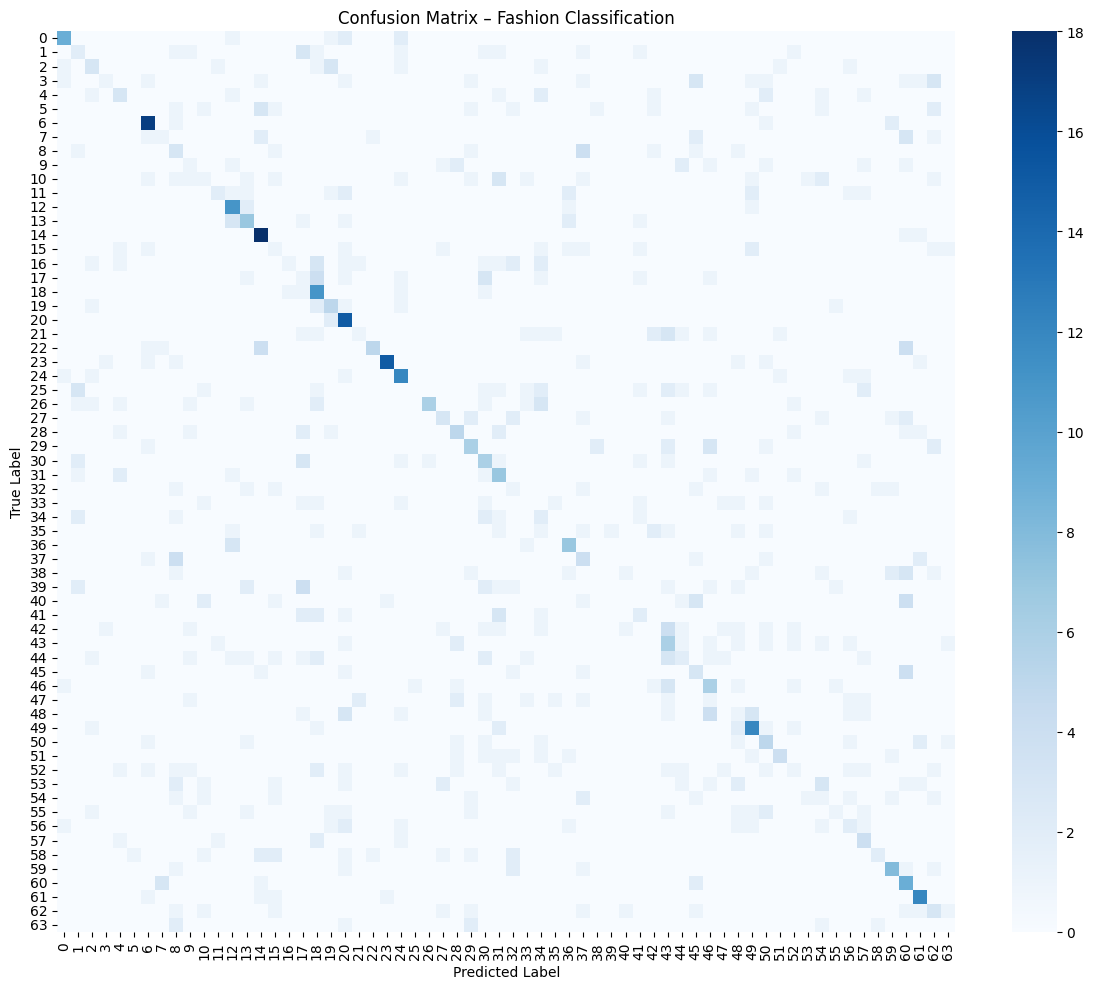

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    cmap="Blues",
    xticklabels=range(NUM_CLASSES),
    yticklabels=range(NUM_CLASSES),
    cbar=True
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Fashion Classification")
plt.tight_layout()
plt.show()

###5.2 Coarse-grained Classification (4 Class)

In [40]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Ambil label asli & prediksi
y_true = []
y_pred = []

for images, labels in cg_test_ds:
    preds = cg_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

####a. Classification Report

In [41]:
# Ambil nama kelas
cg_class_names = list(cg_label_map.keys())

print("=== Coarse-Grained Classification Report ===")
print(classification_report(
    y_true,
    y_pred,
    target_names=cg_class_names,
    digits=4
))

=== Coarse-Grained Classification Report ===
              precision    recall  f1-score   support

      Blazer     0.8558    0.8254    0.8404       338
      Blouse     0.9060    0.9393    0.9224       544
        Coat     0.7273    0.5000    0.5926        16
      Jacket     0.6429    0.5806    0.6102        31

    accuracy                         0.8784       929
   macro avg     0.7830    0.7114    0.7414       929
weighted avg     0.8759    0.8784    0.8764       929



In [42]:
for d in [train_df, val_df, test_df]:
    d["cg_label_name"] = d["label_name"].apply(simplify_label)
    d["cg_label"] = d["cg_label_name"].map(cg_label_map)

In [43]:
cg_class_names = [
    name for name, idx in sorted(cg_label_map.items(), key=lambda x: x[1])
]
print(cg_class_names)

['Blazer', 'Blouse', 'Coat', 'Jacket']


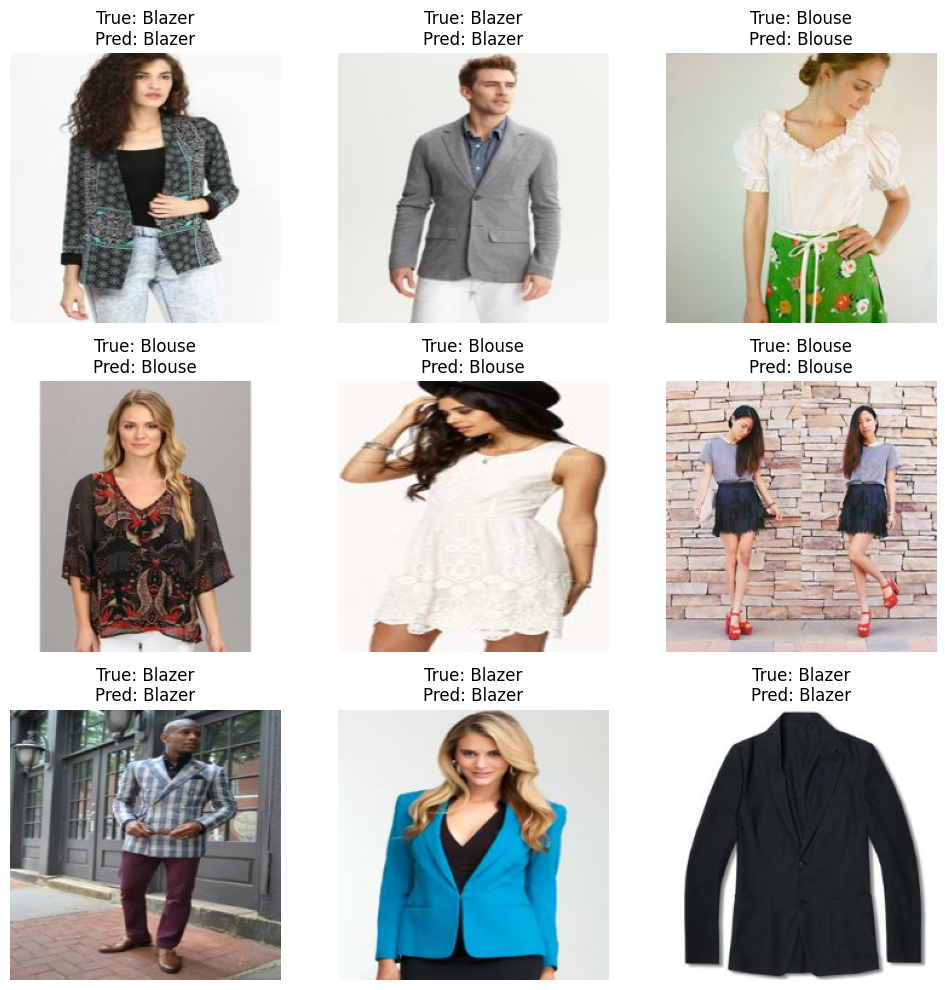

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Ambil 9 sampel dari test set
sample_df = test_df.sample(9, random_state=42)

images = []
labels = []

for _, row in sample_df.iterrows():
    img = load_image_raw(row["path"])   # gambar ASLI (tanpa preprocess)
    images.append(img)
    labels.append(row["cg_label"])      # 🔴 PENTING: coarse label

images = tf.stack(images)
labels = np.array(labels)

# Preprocess untuk model
images_model = tf.keras.applications.efficientnet.preprocess_input(images * 255)

# Prediksi
preds = cg_model.predict(images_model, verbose=0)
preds = np.argmax(preds, axis=1)

# Plot
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy())
    plt.title(
        f"True: {cg_class_names[labels[i]]}\n"
        f"Pred: {cg_class_names[preds[i]]}"
    )
    plt.axis("off")

plt.tight_layout()
plt.show()

####b. Confusion Matrix

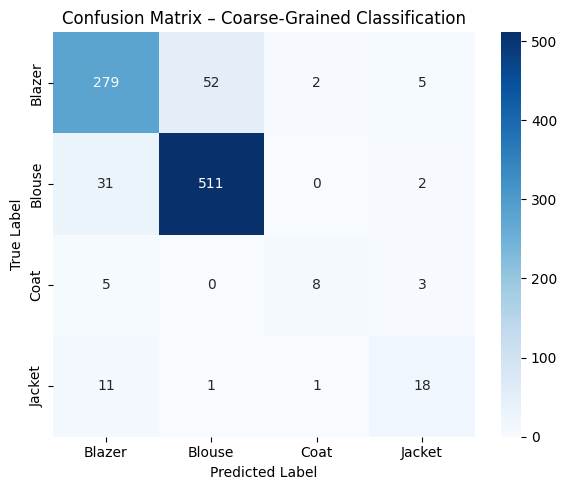

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=cg_class_names,
    yticklabels=cg_class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Coarse-Grained Classification")
plt.tight_layout()
plt.show()